# First order methods for regression models

## Aim

The aim of this material is to code 
- gradient descent (GD)
- accelerated gradient descent (AGD)
- coordinate gradient descent (CD)
- stochastic gradient descent (SGD)
- stochastic variance reduced gradient descent (SVRG)


for the logistic regression models, with the 
ridge penalization.



## To generate the name of your file, use the following

In [1]:
# Change here using your first and last names
fn1 = "halil"
ln1 = "ergun"
fn2 = "douba"
ln2 = "jafuno"
fn3 = "hermann"
ln3 = "djophant"
fn4 = "oumar"
ln4 = "balde"
fn5 = "sakaria"
ln5 = "diarrassouba"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp4", ln1, fn1, ",", ln2, fn2, ",", ln3, fn3, ",", ln4, fn4, "and", ln5, fn5])) + ".ipynb"
print(filename)

tp4_ergun_halil_,_jafuno_douba_,_djophant_hermann_,_balde_oumar_and_diarrassouba_sakaria.ipynb


# Table of content

[1. Introduction](#intro)<br>
[2. Models gradients and losses](#models)<br>
[3. Solvers](#solvers)<br>
[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Introduction

## 1.1. Getting model weights

We'll start by generating sparse vectors and simulating data

In [2]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

## 1.3. Simulation of a logistic regression model

In [3]:
from scipy.linalg import toeplitz

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = np.random.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

Text(0.5, 1.0, 'Logistic regression simulation')

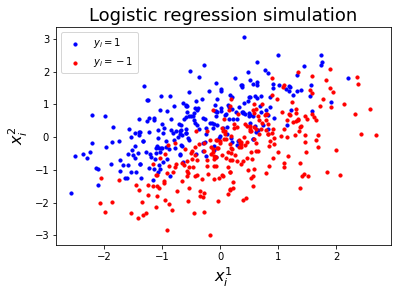

In [4]:
n_samples = 500
w0 = np.array([-3, 3.])
#n_features = len(w0)

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

<a id='models'></a>
# 2. Model gradient and loss

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following case:


**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent.




Expression of $\frac{\partial f(w)}{\partial w_j}$ :

$$ \begin{eqnarray} \frac{\partial f(w)}{\partial w_j}
& = & \frac 1n \sum_{i=1}^n \frac{ \partial \; (1 + e^{-y_i x_i^T w})}{\partial w_j} \frac{1}{1 + e^{-y_i x_i^T w}} + \frac{ \partial \frac{\lambda}{2} \|w\|_2^2}{\partial w_j}\\
& = & \frac 1n \sum_{i=1}^n \frac{ - y_i\; x_{i,j}\; e^{-y_i x_i^T w}}{1 + e^{-y_i x_i^T w}} + \lambda \; w_j
\end{eqnarray} $$

Accorging to http://lcsl.mit.edu/courses/isml2/isml2-2015/scribe14A.pdf, one has :
$$ H(f(w)) = \frac 1n \sum_{i=1}^n x_i x_i^T l^{(2)}(y_i w^T x_i) + \lambda I_d
$$
where $l^{(2)}(a) = \frac{e^{-a}}{(1+e^{-a})^2} \le 1$ 

So one it can be shown that 
$$ L \le \text{the largest eigen value of } ( \frac 1n X^T X + \lambda I_d) $$

## 2.3 Logistic regression


### QUESTIONS

1. Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).

2. Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class below (fill between the TODO and END TODO)

In [5]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        sum=0
        ## Calcul de la somme f(w)
        for i in range (n_samples):
            prod_vect=0
            # calcul du produit vectoriel X*w
            for j in range (self.n_features):
                prod_vect=prod_vect+X[i,j]*w[j]
            sum=sum+np.log(1+np.exp(-y[i]*prod_vect))
        #calcul de la norme ||w||²
        norme=0
        for i in range(self.n_features):
            norme=norme+w[i]**2
        return (((1/n_samples)*sum)+(strength/2)*norme)
        ### END TODO
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        grad = np.empty(self.n_features)
        for j in range (self.n_features):
            sum=0
            for i in range (n_samples):
                prod_vect=0
                for k in range(self.n_features):
                     prod_vect=prod_vect+X[i,k]*w[k]
                sum=sum+(1/(1+np.exp(-y[i]*prod_vect)))*(-y[i])*X[i,j]*np.exp(-y[i]*prod_vect)   
            grad[j]=(1/n_samples)*sum+strength*w[j]
        return (grad)
        ### END TODO

   
        
    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i , strength, y_i= self.X[i], self.strength, self.y[i]
        ### TODO
        grad = np.empty(self.n_features)
        prod_vect=0
        for j in range (self.n_features):
            prod_vect=prod_vect+x_i[j]*w[j]
        for k in range (self.n_features):
            grad[k]=((1/(1+np.exp(-y_i*prod_vect)))*(-y_i)*x_i[k]*np.exp(-y_i*prod_vect))+strength*w[k]   
        return (grad)
                
                

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        return (self.grad(w)[j])
        #vec = np.exp(-y * sum(X.dot(w)) ) 
        #partial = np.sum(- y * X[,j] * dot(vec) / (1+vec) ) / n_samples
        #return(partial)
        ### END TODO

    def lip(self):
        """Computes the Lipschitz constant of grad f"""
        ### TODO
        return(max(self.lip_coordinates()))
        ### END TODO

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the derivative of f^j (f with respect to 
        the j-th coordinate)"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        matrix = self.strength * np.identity(self.n_features) + np.dot(np.transpose(X),X)/n_samples
        eigen_values = np.array(np.linalg.eigvals(matrix))
        return(eigen_values)
        ### END TODO

    def lip_max(self):
        """Computes the maximum of the lipschitz constants of f_i"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        return(self.lip())
        ### END TODO

## 2.4 Checks for the logistic regression model

### QUESTIONS

1. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize`` (see below), as we did for linear regression above

**Remark**: use the function `simu_logreg` to simulate data according to the logistic regression model

In [6]:
from scipy.optimize import check_grad

X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)

w = np.random.randn(model.n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

5.511317768988903e-08


<a id='solvers'></a>
## 3. Solvers

We now have the class `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by logistic regression.

We want now to code and compare several solvers to minimize $f$

<a id='tools'></a>
## 3.1. Tools for the solvers

In [7]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg)
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [8]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent

### QUESTIONS

1. Finish the function `gd` below that implements the gradient descent algorithm
- Test it using the next cell

The GD algorithm (also called steepest descent algorithm) consists in updating the weight parameter $w$ by the following way : 

$$w_{k+1} = w_{k} - \eta_k \nabla f(w_k)$$

where $\eta_k$ is the learning rate (or step).

In [9]:
def gd(model, w0, n_iter, callback, verbose=True):
    """Gradient descent
    """
    step = 1 / model.lip()
    #print(step)
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        w = w - step * model.grad(w)
        ### END TODO
        callback(w)
    return w

In [10]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)


Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.34e-01
      20 | 4.79e-01
      30 | 4.53e-01
      40 | 4.39e-01
      50 | 4.30e-01


<a id='agd'></a>
## 3.3 Accelerated gradient descent

### QUESTIONS

1. Finish the function `agd` below that implements the accelerated gradient descent algorithm
- Test it using the next cell

The AGD algorithm consists in updating the weight parameter $w$ by the following way : 

$$w_{k+1} = t_k - \eta_k \nabla f(t_k)$$
where
$$t_k = w_k + \frac{k-1}{k+2} \left( w_k - w_{k-1} \right)$$

In [11]:
def agd(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    # An extra variable is required for acceleration
    z = w0.copy()
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching AGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        t = w + (k-1)/(k+2) * (w-z)
        w,z = t - step * model.grad(t),w
        
        ### END TODO        
        callback(w)
    return w

In [12]:
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)


Lauching AGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 4.75e-01
      20 | 4.17e-01
      30 | 4.11e-01
      40 | 4.12e-01
      50 | 4.12e-01


<a id='cgd'></a>

## 3.4 Coordinate gradient descent

### QUESTIONS

1. Finish the function `cgd` below that implements the coordinate gradient descent algorithm
- Test it using the next cell

In [13]:
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    indices = np.random.randint(model.n_features,size = n_iter+1)
    for k in range(n_iter + 1):
        ### TODO
        indice = indices[k]
        w[indice] -= steps[indice] * model.grad_coordinate(indice,w)
        ### END TODO        
        callback(w)
    return w

In [14]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 6.17e-01
      20 | 5.14e-01
      30 | 4.83e-01
      40 | 4.63e-01
      50 | 4.47e-01


<a id='sgd'></a>
## 3.5. Stochastic gradient descent

### QUESTIONS

- Finish the function `sgd` below that implements the st stochastic gradient descent algorithm
- Test it using the next cell

The SGD algorithm (Robbins & Monroe, 1951) consists in updating the weight parameter $w$ by the following way : 

$$w_{k+1} = w_{k} - \eta_k \nabla f_{i_k}(w_{k})$$

where $i_k$ is randomly choosed in $\{ 1,...,n \}$ for every $k \geq 1$.

In [15]:
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    w = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        ### TODO
        g=model.grad_i(i,w)
        w=w-step*g


        ### END TODO
        if idx % n_samples == 0:
            callback(w)
    return w

In [16]:
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

   it    |   obj   
       0 | 6.93e-01
      10 | 4.40e-01
      20 | 4.17e-01
      30 | 4.13e-01
      40 | 4.49e-01
      50 | 4.26e-01


<a id='sag'></a>
## 3.6. Stochastic average gradient descent


### QUESTIONS

1. Finish the function `sag` below that implements the stochastic averaged gradient algorithm
- Test it using the next cell

The SAGD algorithm (Schmidt, Le Roux & Bach, 2012) consists in updating the weight parameter $w$ by the following way : 

$$w_{k+1} = w_{k} - \eta_k \frac{1}{n} \sum_{i=1}^n g_i^{k}$$

where $g_{i_k}^k = \nabla f_{i_k}(w_k)$ for $i_k$ randomly choosed in $\{ 1, ..., n \}$ and $g_i^k = g_i^{k-1}$ for every $i \ne i_k$.

In [17]:
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features))
    y = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        ### TODO
        gradient_memory[i]=model.grad_i(i,w)
        w=w-step*(1/n_samples)*sum(gradient_memory)

        ### END OF TODO        
        if idx % n_samples == 0:
            callback(w)
    return w

In [18]:
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

   it    |   obj   
       0 | 6.93e-01
      10 | 4.17e-01
      20 | 4.11e-01
      30 | 4.11e-01
      40 | 4.11e-01
      50 | 4.11e-01


<a id='svrg'></a>
## 3.7. Stochastic variance reduced gradient

### QUESTIONS

- Finish the function `svrg` below that implements the stochastic variance reduced gradient algorithm
- Test it using the next cell

The SVRG algorithm (Johnson & Zhang, 2013) consists in updating the weight parameter $w$ by the following way : 

$$w_{k+1} = w_{k} - \eta_k \left( \nabla f_{i_k}(w_{k}) - \nabla f_{i_k}(\tilde{w}) + \nabla f(\tilde{w}) \right)$$

where $\tilde{w}$ is a snapshot of $w$ that is updated every $m$ iterations (for instance $m = \frac{n}{10}$).

In [19]:
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    callback(w)
    n_samples = model.n_samples
    update_frequency = n_iter/10
    for idx in range(n_iter):        
        ### TODO
        i = idx_samples[idx]
        if idx%update_frequency == 0:  
            w_old = w.copy()       #taking a snapshot of w every (n_iter/10) iterations
            mu = model.grad(w_old)
        g = model.grad_i(i,w)
        g_old = model.grad_i(i,w_old)
        w = w - step*(g - g_old + mu)
        ### END TODO        
        if idx % n_samples == 0:
            callback(w)
    return w

In [20]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 6.93e-01
      10 | 4.29e-01
      20 | 4.11e-01
      30 | 4.11e-01
      40 | 4.11e-01
      50 | 4.11e-01


<a id='comparison'></a>
# 4. Comparison of all algorithms

In [21]:
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

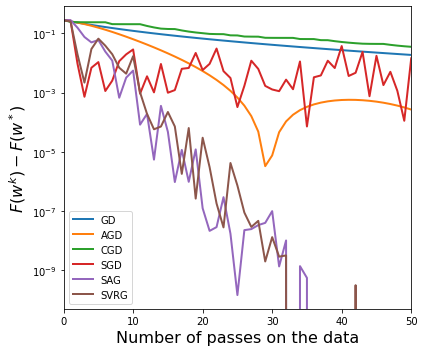

In [22]:
plt.figure(figsize=(6, 5))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

### QUESTIONS

1. Compare the minimizers you obtain using the different algorithms, with a large and a small number of iterations. This can be done with `plt.stem` plots.

- In logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.
- (OPTIONAL) All algorithms can be modified to handle an objective of the form $f + g$ with $g$ separable and prox-capable. Modify all the algorithms and try them out for L1 penalization $f(w) = \lambda \sum_{j=1}^d |w_j|$

Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...
Lauching GD solver...


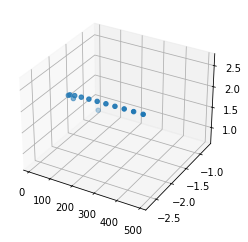

In [23]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

def nothing(model, n_iter=n_iter):
    1+1

l = range(10,500,40)
k = len(l)
vec = np.zeros((k,2))
for i in range(k) :
    vec[i,:] = gd(model, w0,l[i], nothing)


fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(l, vec[:,0], vec[:,1])
plt.show()

### INFLUENCE OF THE CORRELATION 


1. SMALL CORRELATION

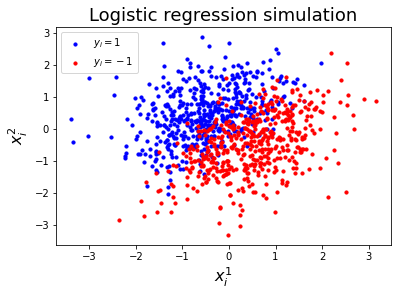

In [24]:
# SMALL CORRELATION ##########################################

w0 = np.array([-3, 3.])
#n_features = len(w0)

X, y = simu_logreg(w0, corr=0.1)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg)
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [25]:
# GD
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

#AGD
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

#CGD
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

#SGD
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

#SAGD
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

#SVRG
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.34e-01
      20 | 4.79e-01
      30 | 4.53e-01
      40 | 4.39e-01
      50 | 4.30e-01
Lauching AGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 4.75e-01
      20 | 4.17e-01
      30 | 4.11e-01
      40 | 4.12e-01
      50 | 4.12e-01
Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.65e-01
      20 | 5.20e-01
      30 | 4.91e-01
      40 | 4.67e-01
      50 | 4.59e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 4.15e-01
      20 | 4.12e-01
      30 | 4.12e-01
      40 | 4.14e-01
      50 | 4.13e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 4.13e-01
      20 | 4.11e-01
      30 | 4.11e-01
      40 | 4.11e-01
      50 | 4.11e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 4.12e-01
      20 | 4.11e-01
      30 | 4.11e-01
      40 | 4.11e-01
      50 | 4.11e-01


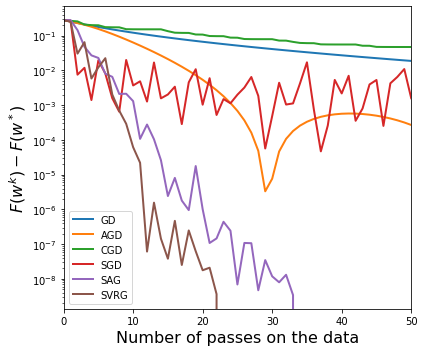

In [26]:
#COMPARISON/PLOTTING
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

plt.figure(figsize=(6, 5))
plt.yscale("log")
for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)
plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

2. HIGHLY CORRELATED

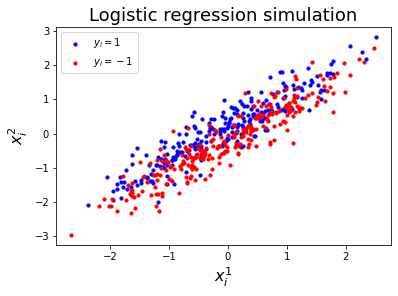

In [27]:
# HIGHLY CORRELATED ##########################################

n_samples = 500
w0 = np.array([-3, 3.])
#n_features = len(w0)

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.9)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg)
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [28]:
# GD
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

#AGD
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

#CGD
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

#SGD
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

#SAGD
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

#SVRG
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.34e-01
      20 | 4.79e-01
      30 | 4.53e-01
      40 | 4.39e-01
      50 | 4.30e-01
Lauching AGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 4.75e-01
      20 | 4.17e-01
      30 | 4.11e-01
      40 | 4.12e-01
      50 | 4.12e-01
Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.43e-01
      20 | 4.85e-01
      30 | 4.68e-01
      40 | 4.51e-01
      50 | 4.39e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 4.12e-01
      20 | 4.18e-01
      30 | 4.18e-01
      40 | 4.18e-01
      50 | 4.13e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 4.12e-01
      20 | 4.11e-01
      30 | 4.11e-01
      40 | 4.11e-01
      50 | 4.11e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 4.28e-01
      20 | 4.11e-01
      30 | 4.11e-01
      40 | 4.11e-01
      50 | 4.11e-01


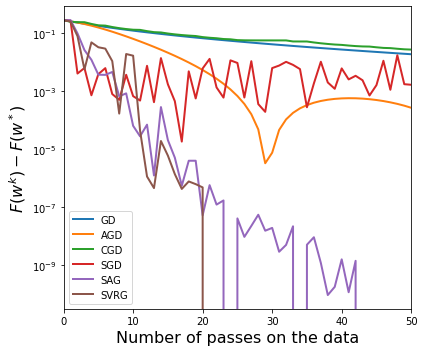

In [29]:
#COMPARISON/PLOTTING
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

plt.figure(figsize=(6, 5))
plt.yscale("log")
for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)
plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

### CONCLUSION ON THE INFLUENCE OF THE CORRELATION 

We observe that SVRG is worst when the data is highly correlated. 
On the contrary, SGD seems to have better performances in this case compared to when the correlation is low.
Moreover, GD, CGD and SAG algorithms doesn't seem to depend on the level of correlation.





### INFLUENCE OF THE RIDGE PENALIZATION


1. Ridge penalization $\lambda = 0.1$

In [30]:
# We set the correlation at 0.4 to study the impact of the ridge penalization.
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, corr=0.4)
model = ModelLogReg(X, y, strength=0.1)

w0 = np.zeros(model.n_features)
n_iter = 50
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [31]:
# GD
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

#AGD
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

#CGD
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

#SGD
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

#SAGD
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

#SVRG
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.42e-01
      20 | 5.35e-01
      30 | 5.35e-01
      40 | 5.35e-01
      50 | 5.35e-01
Lauching AGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.35e-01
      20 | 5.35e-01
      30 | 5.35e-01
      40 | 5.35e-01
      50 | 5.35e-01
Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.50e-01
      20 | 5.37e-01
      30 | 5.35e-01
      40 | 5.35e-01
      50 | 5.35e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 5.46e-01
      20 | 5.38e-01
      30 | 5.43e-01
      40 | 5.39e-01
      50 | 5.36e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 5.35e-01
      20 | 5.35e-01
      30 | 5.35e-01
      40 | 5.35e-01
      50 | 5.35e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 5.37e-01
      20 | 5.35e-01
      30 | 5.35e-01
      40 | 5.35e-01
      50 | 5.35e-01


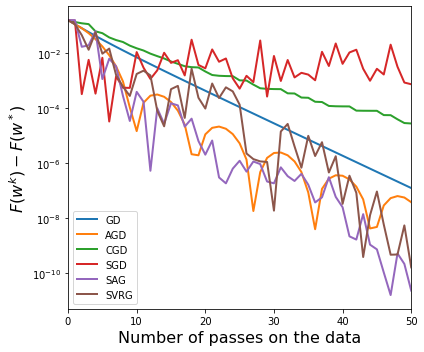

In [32]:
#COMPARISON/PLOTTING
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

plt.figure(figsize=(6, 5))
plt.yscale("log")
for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)
plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

2. Ridge penalization $\lambda = 10^{-6}$

In [33]:
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, corr=0.4)
model = ModelLogReg(X, y, strength=1e-6)

w0 = np.zeros(model.n_features)
n_iter = 50
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [34]:
# GD
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

#AGD
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

#CGD
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

#SGD
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

#SAGD
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

#SVRG
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 4.61e-01
      20 | 4.03e-01
      30 | 3.78e-01
      40 | 3.65e-01
      50 | 3.57e-01
Lauching AGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 3.98e-01
      20 | 3.44e-01
      30 | 3.39e-01
      40 | 3.39e-01
      50 | 3.39e-01
Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 4.99e-01
      20 | 4.37e-01
      30 | 3.99e-01
      40 | 3.81e-01
      50 | 3.69e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 3.49e-01
      20 | 3.43e-01
      30 | 3.41e-01
      40 | 3.39e-01
      50 | 3.43e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 3.39e-01
      20 | 3.39e-01
      30 | 3.39e-01
      40 | 3.39e-01
      50 | 3.39e-01
   it    |   obj   
       0 | 6.93e-01
      10 | 3.39e-01
      20 | 3.39e-01
      30 | 3.39e-01
      40 | 3.39e-01
      50 | 3.39e-01


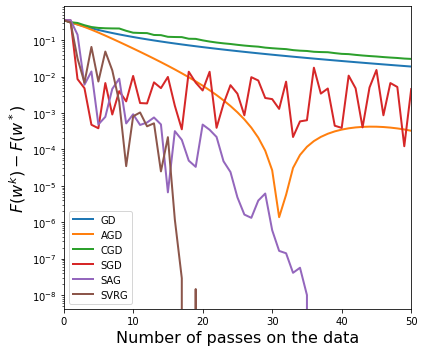

In [35]:
#COMPARISON/PLOTTING
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

plt.figure(figsize=(6, 5))
plt.yscale("log")
for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)
plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

### CONCLUSION ON THE INFLUENCE OF THE RIDGE PENALIZATION

The main difference can be seen when the level of ridge penalization is high ($\lambda = 0.1$). Indeed, we can see that AGD performs better, as well as GD and CGD. The other are performing the same way. 
On the other hand, when the ridge is low ($\lambda = 10^{-3}$ and $10^{-6}$), SVRG and SAG brings significantly better performances compared to the four other algorithms.